<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/machine_learning/nn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [121]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
import math
import matplotlib.pyplot as plt

### **Configuration**

In [122]:
din = 1
dmid = 64
dout = 1
init_int = 0

### **Define Model**

In [123]:
class Model(nnx.Module):
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear3 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear4 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    x1 = nnx.relu(self.linear1(x))
    x2 = nnx.relu(self.linear2(x1))
    x3 = nnx.relu(self.linear3(x2))
    return self.linear4(x3)

### **Initialize Model**

In [124]:
model = Model(din, dmid, dout, nnx.Rngs(init_int))

### **Optimizer**

In [125]:
optimizer = nnx.Optimizer(model, optax.adam(1e-4))  # reference sharing
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'))

### **Initial Predictions**

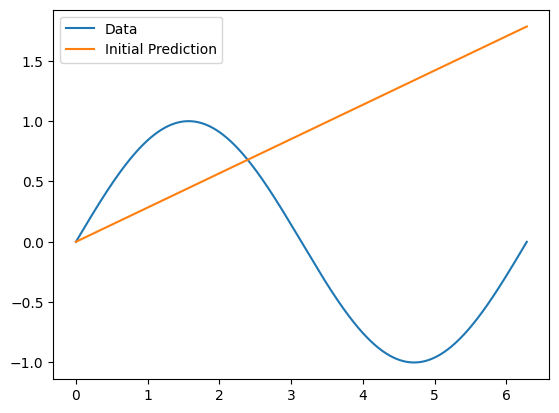

In [126]:
xs = jnp.linspace(0, 2*math.pi, 5000).reshape(-1,1)
ys = jax.vmap(jnp.sin)(xs)
y_hat_init = model(xs)
plt.plot(xs, ys, label='Data')
plt.plot(xs, y_hat_init, label='Initial Prediction')
plt.legend()
plt.show()

### **Trainging Step**

In [127]:
@nnx.jit  # <== currently slow
def train_step(model, optimizer, metrics, x, y):
  def loss_fn(model):
    y_pred = model(x)  # call methods directly
    return ((y_pred - y) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates
  metrics.update(loss=loss)

  return loss

### **Step-by-Step Solver**

In [128]:
loss = train_step(model, optimizer, metrics, xs, ys)

print(f'{loss = }')
print(f'{optimizer.step.value = }')

loss = Array(2.129557, dtype=float32)
optimizer.step.value = Array(1, dtype=uint32)


### **Full Training Run**

In [129]:
model = Model(din, dmid, dout, rngs=nnx.Rngs(init_int))  # eager initialization
optimizer = nnx.Optimizer(model, optax.adam(1e-3))  # reference sharing
loss_history = []
for _ in range(1000):
  loss = train_step(model, optimizer, metrics, xs, ys)
  loss_history.append(loss)

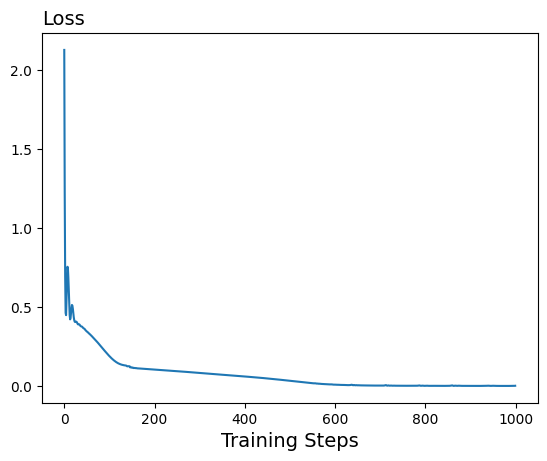

In [130]:
plt.plot(loss_history)
plt.xlabel('Training Steps', size=14)
plt.title('Loss', loc='left', size=14)
plt.show()

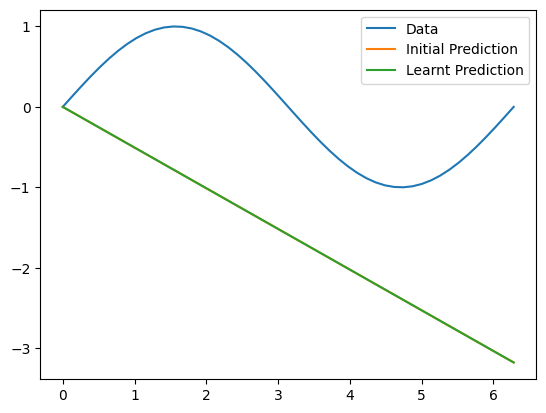

In [133]:
xs = jnp.linspace(0, 2*math.pi).reshape(-1,1)
ys = jax.vmap(jnp.sin)(xs)
y_hat_learnt = model(xs)
plt.plot(xs, ys, label='Data')
plt.plot(xs, y_hat_init, label='Initial Prediction')
plt.plot(xs, y_hat_learnt, label='Learnt Prediction')

plt.legend()
plt.show()

### **Multiple Initializations**

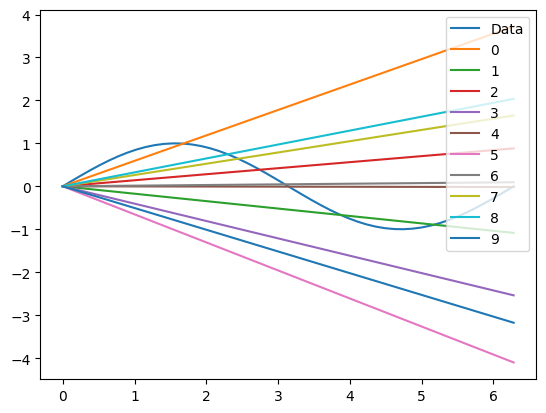

In [132]:
xs = jnp.linspace(0, 2*math.pi).reshape(-1,1)
ys = jax.vmap(jnp.sin)(xs)
plt.plot(xs, ys, label='Data')

for i in range(10):
  model = Model(1, 32, 1, nnx.Rngs(i))
  y_hat_init = model(xs)
  plt.plot(xs, y_hat_init, label=i)
plt.legend()
plt.show()